# Programming Assignment 3
**Pooya Kabiri - 96521434**

Import some prerequisites

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Plotting cell

In [9]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# PART 4

Implementing some helper functions

In [10]:
### From HW2 with slight modifications

def compute_transition(image):
    '''
    Equalizes the histogram of the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result image that it's histogram be eqaulized.   
    '''
    
    h = compute_histogram(image)
    
    ####### your code ########
    n_pixel = image.shape[0] * image.shape[1]
    transition = (h.cumsum().astype(np.float64) / n_pixel) * 255
    ##########################
    return transition  

In [11]:
### From HW2 with slight modifications
def compute_histogram(image):
    '''
    Computes histogram of the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The numpy array of numbers in histogram.   
    '''
    
    histogram = np.zeros((256), np.int)
    
    ####### your code ########
    image = image.astype(int)
    np.add.at(histogram, image, 1)
    ##########################
    
    return histogram

## Histogram Matching
**I used two methods for hisogram matching:**

**1. Linear Interpolation:** In this method, I used Linear Interpolation in NumPy to extract a relation between reference image transition and the reference image itself. Then I used that relation and applied it to the input image, so the result image's histogram is very similar to the ref image.

**2. CDF Matching:** this approach is the traditional approach explained at the class (the usual way). I computed EQ transition for both images and mapped the color intensity values of input image to new values according to ref image transition function.

**Note:** There is a boolean variable *use_interp* in the beginning of the method to determine which method to use.

In [12]:
def histogram_matching(img, ref_img):
    '''
    Matchs the histogram of the input image to the histogram of reference image.
    
    Parameters:
        img (numpy.ndarray): The input image.
        ref_img (numpy.ndarray): The reference image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    out_img = img.copy()
    
    ### For interpolation, set the following variable to true.
    use_interp = True
    
    if use_interp:

        input_transition = compute_transition(img)
        ref_transition = compute_transition(ref_img)
        ref_img_unique = np.unique(ref_img)

        final_transition = np.interp(input_transition, ref_transition, ref_img_unique)

        out_img = final_transition[out_img]
        
    else:
        
        input_transition = compute_transition(img).astype(int)
        ref_transition = compute_transition(ref_img).astype(int)

        transition = np.array([np.where(input_transition[i] <= ref_transition)[0][0] for i in range(256)])

        out_img = transition[out_img]
        
    return out_img

Test of implementation:

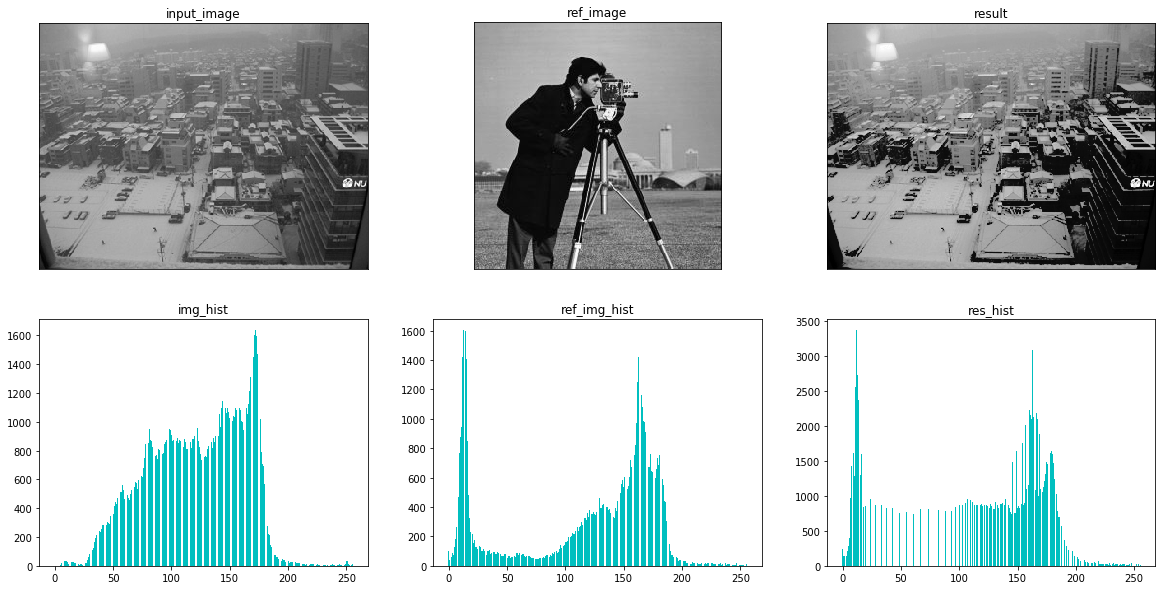

In [13]:
img = cv2.imread(os.path.join('images', 'Q4.jpg'), cv2.IMREAD_GRAYSCALE)
ref_img = cv2.imread(os.path.join('images', 'Q4_ref.jpg'), cv2.IMREAD_GRAYSCALE)
output = histogram_matching(img,ref_img)
h_img = compute_histogram(img)
h_ref_img = compute_histogram(ref_img)
h_out = compute_histogram(output)
image_list = []
image_list.append([img, 'input_image', 'img'])
image_list.append([ref_img, 'ref_image', 'img'])
image_list.append([output, 'result', 'img'])
image_list.append([h_img, 'img_hist', 'hist'])
image_list.append([h_ref_img, 'ref_img_hist', 'hist'])
image_list.append([h_out, 'res_hist', 'hist'])
plotter(image_list, 2, 3, True, 20, 10, 'q4')

# PART 5

Here is my gaussian helper function.

In [14]:
def gaussian(x, y, std):
    return (1 / (2 * np.pi * np.square(std))) * (np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(std))))

## Gaussian Filter
In this method, I implemented the code for creation of a Gausiian Kernel without using prepared libraries.

First, I calculate the value which should be substracted from i and j values (indices of NumPy ndarray) to map them to Cartesian space indices (x and y coordinates). Then I calculate the gaussian function value for each element of the array using it's Cartesian coordinates.

In [15]:
def gaussian_filter(size, std):
    '''
    Creates the Guassian kernel with given size and std.
    
    Parameters:
        size (int): The size of the kernel. It must be odd.
        std (float): The standard deviation of the kernel.
    
    Returns:
        numpy.ndarray: The Guassina kernel.
    '''
    
    kernel = np.zeros((size,size), np.float)
    
    ####### your code ########
    zero_based_gap = np.floor(size / 2)
    
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            x = i - zero_based_gap
            y = j - zero_based_gap
            kernel[i, j] = gaussian(x, y, std)


    ##########################
    return kernel

Using the OpenCV Gaussian Blur function to filter image

In [16]:
def opencv_filter(img):
    '''
    Applys the OpenCV's guassian blur function on input image.
    
    Parameters:
        img (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    ####### your code ########
    out = cv2.GaussianBlur(img, (3, 3), 0)
    ##########################
    
    return out

Test of implementation:

time for applying your guassian filter: 0.007573 s
time for applying OpenCV guassian filter: 0.004658 s


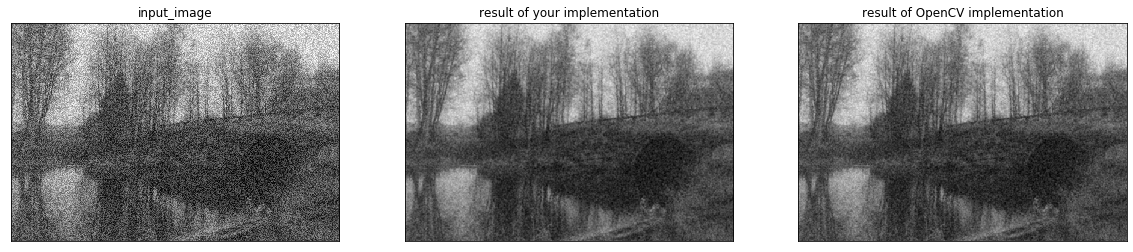

In [17]:
img = cv2.imread(os.path.join('images', 'img5.jpg'), cv2.IMREAD_GRAYSCALE)
size = 3
std = 1
t1 = time.time()
kernel = gaussian_filter(size, std)
out_y_imp = cv2.filter2D(img, -1, kernel)
t2 = time.time()
out_ocv_imp = opencv_filter(img)
t3 = time.time()
print('time for applying your guassian filter: %f s' % (t2 - t1))
print('time for applying OpenCV guassian filter: %f s' % (t3 - t2))
image_list = []
image_list.append([img, 'input_image', 'img'])
image_list.append([out_y_imp, 'result of your implementation', 'img'])
image_list.append([out_ocv_imp, 'result of OpenCV implementation', 'img'])
plotter(image_list, 1, 3, True, 20, 10, 'q5')

#### Result:
**In terms of output image:** The size of the kernel in both examples was identical, and as we can see there is not much of a difference between the images outputed from two methods respectively.

**In terms of computation time** As can be seen above, the OpenCV GaussianBlur function takes less time to run and is more efficient in terms of computation time (and maybe resources).

# CLAHE

**Implementation for theory question 3:** Using OpenCV CLAHE and comparing the results.

In [29]:
def clahe(image, clip_limit):
    '''
    Applys the OpenCV's CLAHE on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result image.   
    '''
    
    out_image = image.copy()
    
    # First creating a OpenCV CLAHE object, with contrast limiting of 2 and tiles size of (10, 10)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(3,3))
    
    # Applying the CLAHE algorithm to the image using the CLAHE object
    out_image = clahe.apply(image)
    
    return out_image

**Now** using the above method for the sample photo provided in HW3 Theory Question no. 3

In [38]:
image = np.array([
    [46, 51, 57, 59],
    [46, 52, 58, 60],
    [46, 52, 58, 60]
], dtype=np.uint8)

output_lim1 = clahe(image, 1.0)
print('With Clip limit of 1:\n', output_lim1)

output_lim2 = clahe(image, 2.0)
print('\nWith Clip limit of 2:\n', output_lim2)

if(output_lim1.all() == output_lim2.all()):
    print('\nTwo outputs are identical!')

With Clip limit of 1:
 [[128 191 160 191]
 [128 255 192 255]
 [128 223 176 223]]

With Clip limit of 2:
 [[128 191 160 191]
 [128 255 192 255]
 [128 223 176 223]]

Two outputs are identical!


**For reasoning, look for Question 3 subsection 3 in HW3_Theory.pdf file**